# exp41

lag_diffのcatboost


https://www.kaggle.com/code/ragnar123/amex-lgbm-dart-cv-0-7977

In [1]:
# ====================================================
# Library
# ====================================================
import gc
import warnings
warnings.filterwarnings('ignore')
import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
import itertools

import lightgbm as lgb
import xgboost as xgb


In [2]:

# ====================================================
# Get the difference
# ====================================================
def get_difference(data, num_features):
    df1 = []
    customer_ids = []
    for customer_id, df in tqdm(data.groupby(['customer_ID'])):
        # Get the differences
        diff_df1 = df[num_features].diff(1).iloc[[-1]].values.astype(np.float32)
        # Append to lists
        df1.append(diff_df1)
        customer_ids.append(customer_id)
    # Concatenate
    df1 = np.concatenate(df1, axis = 0)
    # Transform to dataframe
    df1 = pd.DataFrame(df1, columns = [col + '_diff1' for col in df[num_features].columns])
    # Add customer id
    df1['customer_ID'] = customer_ids
    return df1

# ====================================================
# Read & preprocess data and save it to disk
# ====================================================
def read_preprocess_data():
    train = pd.read_parquet('/content/data/train.parquet')
    features = train.drop(['customer_ID', 'S_2'], axis = 1).columns.to_list()
    cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68",
    ]
    num_features = [col for col in features if col not in cat_features]
    print('Starting training feature engineer...')
    train_num_agg = train.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
    train_num_agg.reset_index(inplace = True)
    train_cat_agg = train.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
    train_cat_agg.reset_index(inplace = True)
    train_labels = pd.read_csv('../input/amex-default-prediction/train_labels.csv')
    # Transform float64 columns to float32
    cols = list(train_num_agg.dtypes[train_num_agg.dtypes == 'float64'].index)
    for col in tqdm(cols):
        train_num_agg[col] = train_num_agg[col].astype(np.float32)
    # Transform int64 columns to int32
    cols = list(train_cat_agg.dtypes[train_cat_agg.dtypes == 'int64'].index)
    for col in tqdm(cols):
        train_cat_agg[col] = train_cat_agg[col].astype(np.int32)
    # Get the difference
    train_diff = get_difference(train, num_features)
    train = train_num_agg.merge(train_cat_agg, how = 'inner', on = 'customer_ID').merge(train_diff, how = 'inner', on = 'customer_ID').merge(train_labels, how = 'inner', on = 'customer_ID')
    del train_num_agg, train_cat_agg, train_diff
    gc.collect()
    test = pd.read_parquet('../input/amex-fe/test_fe.parquet')
    print('Starting test feature engineer...')
    test_num_agg = test.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
    test_num_agg.reset_index(inplace = True)
    test_cat_agg = test.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
    test_cat_agg.reset_index(inplace = True)
    # Transform float64 columns to float32
    cols = list(test_num_agg.dtypes[test_num_agg.dtypes == 'float64'].index)
    for col in tqdm(cols):
        test_num_agg[col] = test_num_agg[col].astype(np.float32)
    # Transform int64 columns to int32
    cols = list(test_cat_agg.dtypes[test_cat_agg.dtypes == 'int64'].index)
    for col in tqdm(cols):
        test_cat_agg[col] = test_cat_agg[col].astype(np.int32)
    # Get the difference
    test_diff = get_difference(test, num_features)
    test = test_num_agg.merge(test_cat_agg, how = 'inner', on = 'customer_ID').merge(test_diff, how = 'inner', on = 'customer_ID')
    del test_num_agg, test_cat_agg, test_diff
    gc.collect()
    # Save files to disk
    train.to_parquet('../input/amex-fe/train_fe.parquet')
    test.to_parquet('../input/amex-fe/test_fe.parquet')

# Read & Preprocess Data
read_preprocess_data()

FileNotFoundError: [Errno 2] No such file or directory: '/content/data/train.parquet'

# Training & Inference

In [3]:
# ====================================================
# Library
# ====================================================
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import random
import scipy as sp
import numpy as np
import pandas as pd
import joblib
import itertools
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from itertools import combinations

import pickle

# ====================================================
# Configurations
# ====================================================
class CFG:
    
    
    # input_dir = '../feature/exp35_lagdiff/'
    input_dir = '../feature/exp03_amex-fe/'
    output_dir = '../output/exp41_cat_lagdiff_c3/'
    seed = 42
    n_folds = 5
    target = 'target'
    boosting_type = 'dart'
    metric = 'binary_logloss'
    model = "cat"
    ver = "exp41"

# ====================================================
# Seed everything
# ====================================================
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# ====================================================
# Read data
# ====================================================
# def read_data():
#     train = pd.read_parquet(CFG.input_dir + 'train_diff.parquet')
#     test = pd.read_parquet(CFG.input_dir + 'test_diff.parquet')
#     return train, test

def read_data():
    train = pd.read_parquet(CFG.input_dir + 'train_fe_plus_plus.parquet')
    test = pd.read_parquet(CFG.input_dir + 'test_fe_plus_plus.parquet')
    return train, test

# ====================================================
# Amex metric
# ====================================================
def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

# ====================================================
# LGBM amex metric
# ====================================================
def lgb_amex_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'amex_metric', amex_metric(y_true, y_pred), True


In [4]:
seed_everything(CFG.seed)

train = pd.read_parquet('../feature/exp38_lagdiff_c3/train_lagdiff_c3.parquet')
test = pd.read_parquet('../feature/exp38_lagdiff_c3/test_lagdiff_c3.parquet')

# train = pd.read_parquet('../feature/exp35_lagdiff/train_lagdiff.parquet')
# test = pd.read_parquet('../feature/exp35_lagdiff/test_lagdiff.parquet')

# # train, test = read_data()

# train_c3 = pd.read_pickle('../feature/exp18_4_tsfresh/train_c3.pkl')
# test_c3 = pd.read_pickle('../feature/exp18_4_tsfresh/test_c3.pkl')

# train = train.merge(train_c3,on = "customer_ID",how = "left")
# test = test.merge(test_c3,on = "customer_ID",how = "left")

# del train_c3,test_c3
# gc.collect

# print(train.shape)
# print(test.shape)

In [5]:

def xgb_amex(y_pred, y_true):
    return 'amex', amex_metric_np(y_pred,y_true.get_label())


def cat_amex(y_pred, y_true):
    return 'amex', amex_metric_np(y_pred,y_true.get_label())


def amex_metric_np(preds: np.ndarray, target: np.ndarray) -> float:
    indices = np.argsort(preds)[::-1]
    preds, target = preds[indices], target[indices]

    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    d = np.sum(target[four_pct_mask]) / np.sum(target)

    weighted_target = target * weight
    lorentz = (weighted_target / weighted_target.sum()).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    n_pos = np.sum(target)
    n_neg = target.shape[0] - n_pos
    gini_max = 10 * n_neg * (n_pos + 20 * n_neg - 19) / (n_pos + 20 * n_neg)

    g = gini / gini_max
    return 0.5 * (g + d)

In [6]:

from catboost import CatBoostClassifier

cat_features = [
    "B_30",
    "B_38",
    "D_114",
    "D_116",
    "D_117",
    "D_120",
    "D_126",
    "D_63",
    "D_64",
    "D_66",
    "D_68"
]

# kmeans_list = ["kmeans pred 2","kmeans pred 3","kmeans pred 4"]

cat_features = [f"{cf}_last" for cf in cat_features]
# cat_features.extend(kmeans_list)

for cat_col in cat_features:
#     print(cat_col)
    encoder = LabelEncoder()
    train[cat_col] = encoder.fit_transform(train[cat_col])
    test[cat_col] = encoder.transform(test[cat_col])


features = [col for col in train.columns if col not in ['customer_ID', CFG.target]]

prams = {
    'depth': 8,
    'iterations':9999,#9999
    'learning_rate': 0.02,
    'random_state':CFG.seed,
    'task_type':"CPU",
    'early_stopping_rounds': 300,
    # 'custom_metric' : 'cat_amex'
}

# Create a numpy array to store test predictions
test_predictions = np.zeros(len(test))
# Create a numpy array to store out of folds predictions
oof_predictions = []

cids = []
tr_target = []

kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[CFG.target])):
    print(' ')
    print('-'*50)
    print(f'Training fold {fold} with {len(features)} features...')
    x_train, x_val = train[features].iloc[trn_ind], train[features].iloc[val_ind]
    y_train, y_val = train[CFG.target].iloc[trn_ind], train[CFG.target].iloc[val_ind]
#     lgb_train = lgb.Dataset(x_train, y_train, categorical_feature = cat_features)
#     lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature = cat_features)
    
#     des = DartEarlyStopping("valid_1", CFG.metric, 1000)
    
    model = CatBoostClassifier(**prams)
    
    model.fit(x_train, y_train,
                  eval_set = [(x_val, y_val)], 
                  metric_period=100
                 )
    
#     model = lgb.train(
#         params = params,
#         train_set = lgb_train,
#         num_boost_round = epoch[fold],#10500
#         valid_sets = [lgb_train, lgb_valid],
#         early_stopping_rounds = 1500,
# #         eval_metric=[lgb_amex_metric],
#         verbose_eval = 500,
#         feval = lgb_amex_metric
#         )
    
    # Save best model
    model.save_model(f"{CFG.output_dir}{CFG.model}_fold{fold}_seed{CFG.seed}.cbm")
    joblib.dump(model, f'{CFG.output_dir}lgbm_{CFG.boosting_type}_fold{fold}_seed{CFG.seed}.pkl')
    # Predict validation
    
    val_pred = model.predict_proba(x_val)[:,1]
    oof_predictions.extend(val_pred)
    
    
    cids.extend(train["customer_ID"].loc[val_ind])
    tr_target.extend(train["target"].loc[val_ind])
    
    # Predict the test set
    test_pred = model.predict_proba(test[features])[:,1]
    # test_pred = model.predict(test[features])
    test_predictions += test_pred / CFG.n_folds
    # Compute fold metric
    
    score = amex_metric(y_val, val_pred)
    print(f'Our fold {fold} CV score is {score}')
    del x_train, x_val, y_train, y_val
    gc.collect()
    
# Compute out of folds metric
score = amex_metric(tr_target, oof_predictions)
print(f'Our out of folds CV score is {score}')


# Create a dataframe to store test prediction
test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
# test_df.to_csv(f'{CFG.output_dir}test_{CFG.model}_{score}_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)
test_df.to_csv(f'{CFG.output_dir}test_{CFG.ver}_{CFG.model}_{score}_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)


dic_oof = {
    "customer_ID":cids,
    "target":tr_target,
    f"{CFG.ver}_{CFG.model}_oof":oof_predictions
}

# Create a dataframe to store out of folds predictions
oof_df = pd.DataFrame(dic_oof)
# oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
oof_df.to_csv(f'{CFG.output_dir}oof_{CFG.ver}_{CFG.model}_{score}_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)


# # Create a dataframe to store out of folds predictions
# oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
# oof_df.to_csv(f'../output/Amex LGBM Dart CV 0.7977/oof_lgbm_{CFG.boosting_type}_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)


# # Create a dataframe to store test prediction
# test_df = pd.DataFrame({'customer_ID': test['customer_ID'], 'prediction': test_predictions})
# test_df.to_csv(f'../output/Amex LGBM Dart CV 0.7977/test_lgbm_{CFG.boosting_type}_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)


 
--------------------------------------------------
Training fold 0 with 2011 features...


0:	learn: 0.6671410	test: 0.6670561	best: 0.6670561 (0)	total: 831ms	remaining: 2h 18m 25s
100:	learn: 0.2438105	test: 0.2433128	best: 0.2433128 (100)	total: 1m 8s	remaining: 1h 51m 18s
200:	learn: 0.2290271	test: 0.2295302	best: 0.2295302 (200)	total: 2m 13s	remaining: 1h 48m 33s
300:	learn: 0.2234682	test: 0.2251648	best: 0.2251648 (300)	total: 3m 18s	remaining: 1h 46m 39s
400:	learn: 0.2197603	test: 0.2227460	best: 0.2227460 (400)	total: 4m 24s	remaining: 1h 45m 32s
500:	learn: 0.2168978	test: 0.2211216	best: 0.2211216 (500)	total: 5m 30s	remaining: 1h 44m 21s
600:	learn: 0.2144838	test: 0.2200045	best: 0.2200045 (600)	total: 6m 35s	remaining: 1h 42m 59s
700:	learn: 0.2120917	test: 0.2190235	best: 0.2190235 (700)	total: 7m 38s	remaining: 1h 41m 22s
800:	learn: 0.2097026	test: 0.2183041	best: 0.2183041 (800)	total: 8m 43s	remaining: 1h 40m 10s
900:	learn: 0.2075532	test: 0.2178139	best: 0.2178139 (900)	total: 9m 47s	remaining: 1h 38m 49s
1000:	learn: 0.2055559	test: 0.2174255	best: 0

0:	learn: 0.6670383	test: 0.6669980	best: 0.6669980 (0)	total: 692ms	remaining: 1h 55m 20s
100:	learn: 0.2433332	test: 0.2450192	best: 0.2450192 (100)	total: 1m 9s	remaining: 1h 52m 53s
200:	learn: 0.2283569	test: 0.2319330	best: 0.2319330 (200)	total: 2m 13s	remaining: 1h 48m 33s
300:	learn: 0.2226553	test: 0.2276621	best: 0.2276621 (300)	total: 3m 20s	remaining: 1h 47m 54s
400:	learn: 0.2189665	test: 0.2253524	best: 0.2253524 (400)	total: 4m 28s	remaining: 1h 46m 56s
500:	learn: 0.2161044	test: 0.2238922	best: 0.2238922 (500)	total: 5m 33s	remaining: 1h 45m 22s
600:	learn: 0.2136317	test: 0.2228889	best: 0.2228889 (600)	total: 6m 37s	remaining: 1h 43m 43s
700:	learn: 0.2112244	test: 0.2220402	best: 0.2220402 (700)	total: 7m 42s	remaining: 1h 42m 12s
800:	learn: 0.2087526	test: 0.2213731	best: 0.2213731 (800)	total: 8m 46s	remaining: 1h 40m 43s
900:	learn: 0.2065204	test: 0.2208923	best: 0.2208923 (900)	total: 9m 49s	remaining: 1h 39m 15s
1000:	learn: 0.2043784	test: 0.2204884	best: 0

0:	learn: 0.6668176	test: 0.6668913	best: 0.6668913 (0)	total: 717ms	remaining: 1h 59m 30s
100:	learn: 0.2434391	test: 0.2453943	best: 0.2453943 (100)	total: 1m 8s	remaining: 1h 52m 32s
200:	learn: 0.2284603	test: 0.2317174	best: 0.2317174 (200)	total: 2m 14s	remaining: 1h 49m 12s
300:	learn: 0.2227644	test: 0.2273875	best: 0.2273875 (300)	total: 3m 19s	remaining: 1h 47m 20s
400:	learn: 0.2190817	test: 0.2250342	best: 0.2250342 (400)	total: 4m 25s	remaining: 1h 45m 50s
500:	learn: 0.2162347	test: 0.2235030	best: 0.2235030 (500)	total: 5m 30s	remaining: 1h 44m 25s
600:	learn: 0.2137261	test: 0.2224984	best: 0.2224984 (600)	total: 6m 36s	remaining: 1h 43m 14s
700:	learn: 0.2113290	test: 0.2215823	best: 0.2215823 (700)	total: 7m 40s	remaining: 1h 41m 42s
800:	learn: 0.2089882	test: 0.2208533	best: 0.2208533 (800)	total: 8m 43s	remaining: 1h 40m 9s
900:	learn: 0.2067986	test: 0.2203258	best: 0.2203258 (900)	total: 9m 46s	remaining: 1h 38m 41s
1000:	learn: 0.2047918	test: 0.2199257	best: 0.

0:	learn: 0.6662388	test: 0.6663464	best: 0.6663464 (0)	total: 724ms	remaining: 2h 39s
100:	learn: 0.2429659	test: 0.2462268	best: 0.2462268 (100)	total: 1m 8s	remaining: 1h 51m 17s
200:	learn: 0.2280590	test: 0.2328725	best: 0.2328725 (200)	total: 2m 13s	remaining: 1h 48m 16s
300:	learn: 0.2223657	test: 0.2286101	best: 0.2286101 (300)	total: 3m 18s	remaining: 1h 46m 49s
400:	learn: 0.2187261	test: 0.2263129	best: 0.2263129 (400)	total: 4m 24s	remaining: 1h 45m 29s
500:	learn: 0.2158647	test: 0.2248193	best: 0.2248193 (500)	total: 5m 30s	remaining: 1h 44m 25s
600:	learn: 0.2133732	test: 0.2237316	best: 0.2237316 (600)	total: 6m 36s	remaining: 1h 43m 13s
700:	learn: 0.2109964	test: 0.2228364	best: 0.2228364 (700)	total: 7m 40s	remaining: 1h 41m 48s
800:	learn: 0.2086003	test: 0.2221466	best: 0.2221466 (800)	total: 8m 44s	remaining: 1h 40m 19s
900:	learn: 0.2064529	test: 0.2216239	best: 0.2216225 (899)	total: 9m 47s	remaining: 1h 38m 52s
1000:	learn: 0.2044527	test: 0.2212601	best: 0.221

0:	learn: 0.6672867	test: 0.6672833	best: 0.6672833 (0)	total: 751ms	remaining: 2h 5m 5s
100:	learn: 0.2436706	test: 0.2445491	best: 0.2445491 (100)	total: 1m 9s	remaining: 1h 53m 16s
200:	learn: 0.2288326	test: 0.2305711	best: 0.2305711 (200)	total: 2m 14s	remaining: 1h 49m 25s
300:	learn: 0.2232584	test: 0.2262201	best: 0.2262201 (300)	total: 3m 20s	remaining: 1h 47m 47s
400:	learn: 0.2196534	test: 0.2239250	best: 0.2239250 (400)	total: 4m 26s	remaining: 1h 46m 11s
500:	learn: 0.2167523	test: 0.2223452	best: 0.2223452 (500)	total: 5m 31s	remaining: 1h 44m 45s
600:	learn: 0.2142743	test: 0.2212024	best: 0.2212024 (600)	total: 6m 36s	remaining: 1h 43m 25s
700:	learn: 0.2118927	test: 0.2203237	best: 0.2203237 (700)	total: 7m 40s	remaining: 1h 41m 45s
800:	learn: 0.2094995	test: 0.2195767	best: 0.2195767 (800)	total: 8m 44s	remaining: 1h 40m 22s
900:	learn: 0.2073000	test: 0.2189760	best: 0.2189760 (900)	total: 9m 48s	remaining: 1h 38m 58s
1000:	learn: 0.2052738	test: 0.2185270	best: 0.2

<AxesSubplot:>

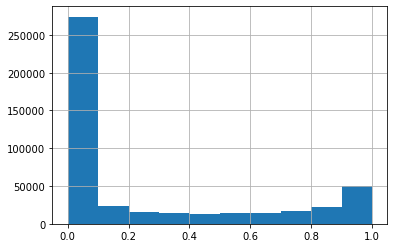

In [7]:
oof_df[f"{CFG.ver}_{CFG.model}_oof"].hist()

In [19]:
len(oof_df)

458913